In [1]:
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, OverlandFlow
# from landlab.plot import imshow_grid
import matplotlib.pyplot as plt
import numpy as np
import rasterio
# from rasterio.plot import show

# Utility functions
def show_plot_2d(val_grd: np.ndarray,
                 z_label = 'Elevation (m)',
                 title = 'DEM',
                 cmap = 'terrain'):
    fig, ax = plt.subplots()
    im = ax.imshow(val_grd, cmap = cmap)
    cb = fig.colorbar(im, ax = ax)
    cb.set_label(z_label)
    ax.set(title = title, xlabel = 'X', ylabel = 'Y')
    plt.show()

def show_plot_3d(x_axis_grd: np.ndarray,
                 y_axis_grd: np.ndarray,
                 val_grd: np.ndarray,
                 z_label = 'Elevation (m)',
                 title = 'DEM',
                 cmap = 'terrain'):
    fig, ax = plt.subplots(subplot_kw = {'projection': '3d'})
    ax.plot_surface(x_axis_grd, y_axis_grd, val_grd, cmap = cmap, linewidth = 0, antialiased = True)
    ax.set(title = title, xlabel = 'X', ylabel = 'Y', zlabel = z_label)
    ax.set_proj_type('persp', focal_length = 0.3)
    ax.view_init(azim = -45, elev = 50)
    plt.show()

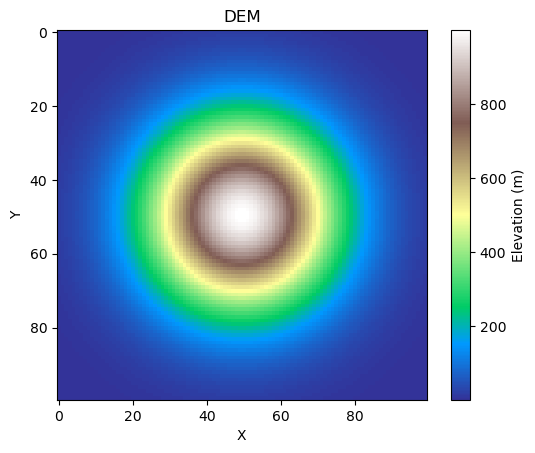

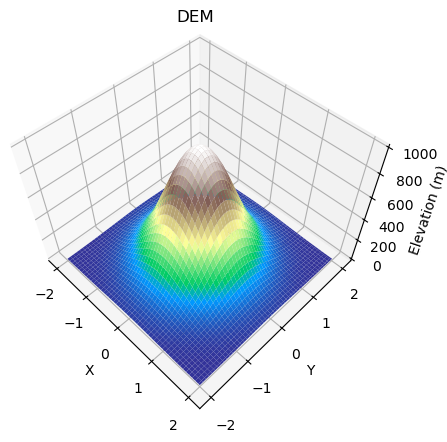

In [2]:
# Create base and heights (Gaissian Hill)
boundary = 2
dem_width, dem_height = (100, 100)
x_grd, y_grd = np.meshgrid(np.linspace(-boundary, boundary, dem_width), np.linspace(-boundary, boundary, dem_height))
z_grd        = np.exp(-x_grd * x_grd - y_grd * y_grd) * 1000

# Show plot
show_plot_2d(z_grd)
show_plot_3d(x_grd, y_grd, z_grd)

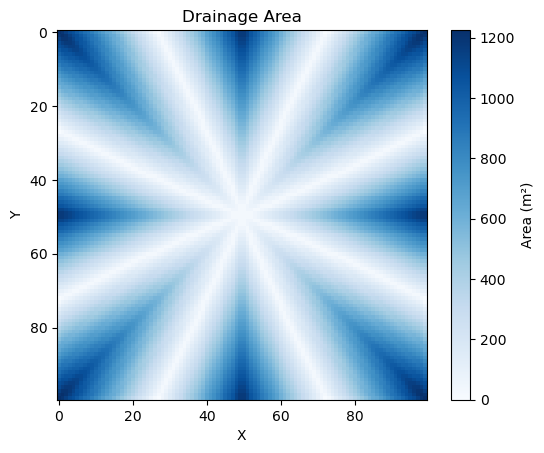

In [3]:
# Convert to Landlab format
cell_size = 5
mg = RasterModelGrid((dem_width, dem_height), cell_size)
mg.add_field('topographic__elevation', z_grd, at = 'node', units = 'meters', clobber = False)

# Calculate flow accumulation
FlowAccumulator(mg, flow_director = 'D8').run_one_step()
fa_grd = mg.at_node['drainage_area'].reshape((dem_width, dem_height))

# Show plot
show_plot_2d(fa_grd, 'Area (m²)', 'Drainage Area', 'Blues')

del boundary, cell_size, dem_height, dem_width, fa_grd, mg, x_grd, y_grd, z_grd

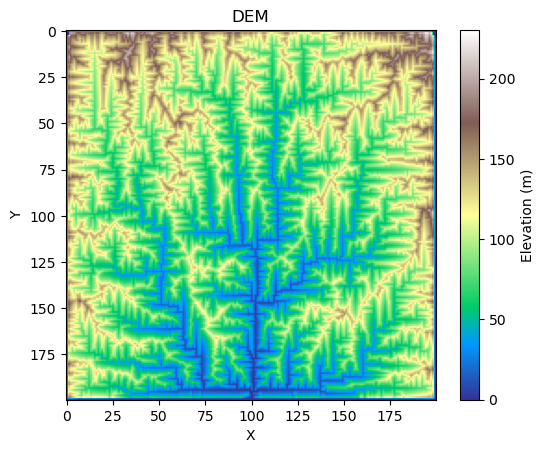

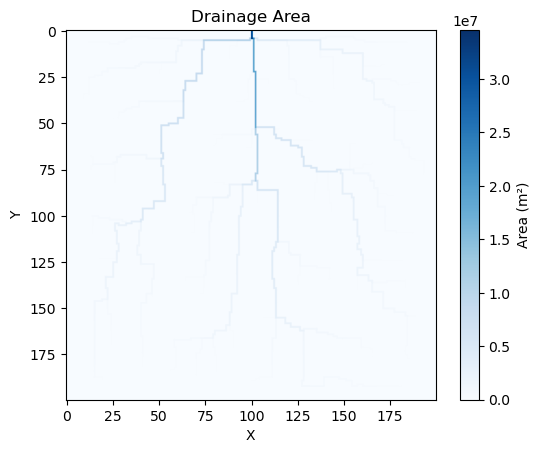

In [4]:
mg: RasterModelGrid
x_grd: np.ndarray
y_grd: np.ndarray
z_grd: np.ndarray

# Read external DEM
with rasterio.open(r'..\src\Practice.tif') as f:
    z_grd = f.read(1)
    z_grd[z_grd == -9999] = 0
    row_grd, col_grd = np.meshgrid(np.arange(z_grd.shape[0]), np.arange(z_grd.shape[1]))
    x_grd, y_grd = rasterio.transform.xy(f.transform, col_grd, row_grd)
    x_grd = x_grd.reshape(z_grd.shape)
    y_grd = y_grd.reshape(z_grd.shape)

    del col_grd, row_grd

# Generate a raster grid
mg = RasterModelGrid((f.width, f.height), f.transform.a, (f.bounds[0], f.bounds[1]))    # Origin is situated in bottom left
z_arr = mg.add_zeros('topographic__elevation', at = 'node', clobber = True)
z_arr += z_grd[::-1, :].ravel()

# Calculate flow accumulation
FlowAccumulator(mg).run_one_step()
fa_grd = mg.at_node['drainage_area'].reshape(z_grd.shape)

# Show plot
show_plot_2d(z_grd)
# show_plot_3d(x_grd, y_grd, z_grd)
show_plot_2d(fa_grd, 'Area (m²)', 'Drainage Area', 'Blues')

del f, z_arr

In [8]:
# Define outlet node
outlet_node = 300
outlet_link = mg.links_at_node[outlet_node][1]

# Calculate overlandflow
mg.add_zeros('surface_water__depth', at = 'node', clobber = True)
of_ini = OverlandFlow(mg, alpha = 0.45, steep_slopes = True)
of_ini.run_one_step()

elapsed_time = 1        # Initial time (s)
precip_amt   = 5        # Precipitation amount (mm/hr)
storm_durn   = 7200     # Storm duration (s)
total_durn   = 43200    # Total simulating duration (s)

dschrge_arr = []        # Discharge array
elapsed_arr = []        # Elapsed time array

while elapsed_time < total_durn:
    of_ini.dt = of_ini.calc_time_step()

    if elapsed_time < storm_durn:   # Raining
        of_ini.rainfall_intensity = precip_amt * (2.78 * 10 ** -7)  # Convert from mm/hr to m/s
    else:                           # Not raining
        of_ini.rainfall_intensity = 0

    of_ini.run_one_step()
    elapsed_arr.append(elapsed_time)
    dschrge_arr.append(np.abs(mg.at_link['surface_water__discharge'][outlet_link]) * mg.dx)
    elapsed_time += of_ini.dt       # Loop

del elapsed_time, of_ini, precip_amt, outlet_link

In [17]:
precip_arr = np.zeros(len(elapsed_arr))
precip_arr[np.array(elapsed_arr) <= storm_durn] = 5 * (2.78 * 10 ** -4)

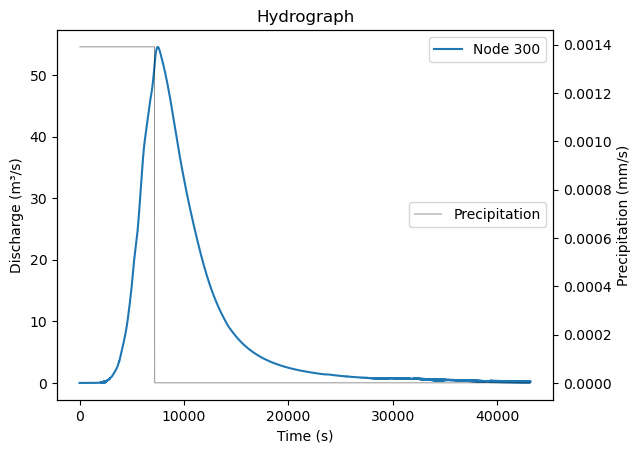

In [30]:
# Plot result
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(elapsed_arr, dschrge_arr, label = 'Node 300')
ax2.plot(elapsed_arr,  precip_arr, label = 'Precipitation', c = 'black', lw = 0.3)
ax.set(title = f'Hydrograph', xlabel = 'Time (s)', ylabel = 'Discharge (m³/s)')
ax2.set(ylabel = 'Precipitation (mm/s)')
ax.legend()
ax2.legend(loc = 5)
plt.show()

In [10]:
np.argmax(fa_grd)

np.int64(100)